Important: The cells must be run from top to bottom sequentially.

It is necessary to create a folder ”ml-25m” in the same directory as the
ipynb file, and the ”ml-25m” folder should contain a file ratings.csv, which are
the ratings from MovieLens.

# Loading MovieLens data

ratingsS would be the final 3000x3000 data for our analysis


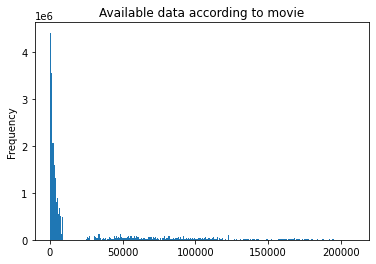

Unique users:  3000
Unique movies:  3000
Entries:  3056972
Ratio:  0.33966355555555555


,userId,movieId,rating,timestamp,uid_matrix,mid_matrix
23893,187,1,3.5,1277374478,0,0
51820,426,1,2.5,1452025761,1,0
68417,548,1,4.5,1431644949,2,0
81298,626,1,4.5,1136304145,3,0
99605,757,1,3.0,1184013452,4,0
...,...,...,...,...,...,...
24884961,161826,1483,3.0,1275237465,2993,641
24899629,161928,1483,2.5,1426701876,2994,641
24914705,162047,1483,3.0,1459091598,2995,641
24950248,162271,1483,2.0,1180311050,2996,641


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load all data from MovieLens
def load_data():
    global genome_scores,genome_tags,links,movies,ratings,tags,data_initialized
    if 'data_initialized' not in globals():
        ratings = pd.read_csv("ml-25m/ratings.csv")
        data_initialized = True

# sample the dataframe by key, where we keep only the data with values of the column key
# with the largest occurences in the whole data frame
def filter_largest_occurences(dataframe, key, count):
    df2 = dataframe.groupby(by = key).count()
    largest = df2.nlargest(count, list(df2.columns)[0])
    largest = largest.index.values
    return dataframe[ dataframe[key].isin(largest) ]

# print the unique number of users, movies, total entries, and the
# entries / no.users * no.movies ratio
def print_data_info(dataframe):
    print("Unique users: ", len(dataframe["userId"].unique()))
    print("Unique movies: ", len(dataframe["movieId"].unique()))
    print("Entries: ", len(dataframe))
    print("Ratio: ", len(dataframe) / (len(dataframe["userId"].unique()) * len(dataframe["movieId"].unique())))

load_data()

# mplot = ratingsS.plot(kind = 'scatter', x = "userId", y = "movieId")
# plt.show()

mplot = ratings['movieId'].plot.hist(bins = 300)
plt.title("Available data according to movie")
plt.show()

# find largest 10000 movies
ratingsS = filter_largest_occurences(ratings, "movieId", 10000)
# find largest 10000 movie watchers
ratingsS = filter_largest_occurences(ratingsS, "userId", 10000)

# further restrict to 3000x3000
ratingsS = filter_largest_occurences(ratingsS, "movieId", 3000)
ratingsS = filter_largest_occurences(ratingsS, "userId", 3000)

# obtain a bijection of userId with the matrix entry, and do the same for movieId.
users = ratingsS["userId"].unique()
movies = ratingsS["movieId"].unique()
users.sort()
movies.sort()

users_lookup = pd.DataFrame(data = np.array([users, np.arange(len(users))]).transpose(), columns = ["userId", "uid_matrix"])
movies_lookup = pd.DataFrame(data = np.array([movies, np.arange(len(movies))]).transpose(), columns = ["movieId", "mid_matrix"])

# join to obtain list of locations
ratingsS = ratingsS.join(users_lookup.set_index('userId'), how="inner", on="userId")\
    .join(movies_lookup.set_index('movieId'), how='inner', on="movieId")
print_data_info(ratingsS)

display(ratingsS)

# ratings[["userId", "movieId"]]

# Partition into 10 random subsets for cross-validation

In [2]:
import math

# basically, first permute the ratings, and then divide into equally sized partitions.
def generate_random_subsets(divisions = 10):
    while True:
        # permute the ratings here
        ratingsPerm = ratingsS.copy()
        ratingsPerm = ratingsPerm.sample(frac=1)
        total_entries = len(ratingsPerm)
        
        # divide into partitions here
        part_size = int(math.floor(total_entries / (divisions+0.0)))
        ratingsSubsample = []
        ratingsSubsamplePivot = []
        enough_user_movies = True

        for k in range(divisions):
            start_range = k * part_size
            end_range = (k+1) * part_size
            subsample = ratingsPerm.iloc[start_range:end_range]
            if (len(subsample["userId"].unique()) < len(ratingsS["userId"].unique())) or \
            (len(subsample["movieId"].unique()) < len(ratingsS["movieId"].unique())):
                enough_user_movies = False
                break

            ratingsSubsample.append(subsample)
        
        # if one of the partitions happen to have less than 3000 users or movies, we repeat the whole process
        if not enough_user_movies:
            continue

        for k in range(divisions):
            subsample = ratingsSubsample[k]
            df_train_subsample = subsample.pivot(index = "userId", columns = "movieId", values = "rating")
            ratingsSubsamplePivot.append(df_train_subsample)
        return ratingsSubsample, ratingsSubsamplePivot

divisions = 10
ratingsSubsample, ratingsSubsamplePivot = generate_random_subsets(divisions)
for k in range(divisions):
    print("------------------ Data",k,"------------------")
    print_data_info(ratingsSubsample[k])

------------------ Data 0 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 1 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 2 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 3 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 4 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 5 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 6 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 7 ------------------
Unique users:  3000
Unique movi

# Use the SVT algorithm for MovieLens data
### If the SVT algorithm does not converge (exception happens), use step_size=1.99 for safety

-------------------------- Running with data  0  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1919.5707202392935     nuc: 0.0      last rank: 0
fro:  1574.9500362886547     nuc: 1658.3303677691329      last rank: 1
fro:  1344.0703796329835     nuc: 2898.2732283409314      last rank: 1
fro:  1191.2051131542266     nuc: 3827.216157713603      last rank: 1
fro:  1087.527656677296     nuc: 4533.730111940873      last rank: 1
fro:  1013.8151648769076     nuc: 5081.556422813

fro:  421.63414329714635     nuc: 9642.499634187934      last rank: 3
fro:  420.9149647131577     nuc: 9640.877853616767      last rank: 3
fro:  420.3316991957581     nuc: 9638.870307780799      last rank: 3
fro:  419.84445773269925     nuc: 9636.687767131105      last rank: 3
fro:  419.4263587037314     nuc: 9634.47748165343      last rank: 3
fro:  419.0590819794947     nuc: 9632.339823722094      last rank: 3
fro:  418.7299725480713     nuc: 9630.340851855286      last rank: 3
fro:  418.4301513600529     nuc: 9628.52174804897      last rank: 3
fro:  418.15327926211097     nuc: 9626.905871145267      last rank: 3
fro:  417.8947442718795     nuc: 9625.504000799097      last rank: 3
fro:  417.6511236765627     nuc: 9624.318214092356      last rank: 3
fro:  417.4198250805703     nuc: 9623.3447332354      last rank: 3
fro:  417.1988444874166     nuc: 9622.576002393791      last rank: 3
fro:  416.98660135637556     nuc: 9622.00218967767      last rank: 3
fro:  416.781824629425     nuc: 962

fro:  266.9948533266236     nuc: 9404.830421606628      last rank: 60
fro:  265.2838505071267     nuc: 9402.265276964037      last rank: 61
fro:  263.70432363501334     nuc: 9399.674112976438      last rank: 62
fro:  262.0364139206308     nuc: 9397.128257008946      last rank: 63
fro:  260.3278504195595     nuc: 9394.55885700637      last rank: 64
fro:  258.7069041457581     nuc: 9391.95969987728      last rank: 65
fro:  257.098364556515     nuc: 9389.38621698671      last rank: 65
fro:  255.65744203440374     nuc: 9386.83269293797      last rank: 66
fro:  254.14987466211664     nuc: 9384.361183366593      last rank: 67
fro:  252.53552162354936     nuc: 9381.892472130414      last rank: 68
fro:  250.78279406335437     nuc: 9379.386420151845      last rank: 70
fro:  249.08587963674825     nuc: 9376.815967530387      last rank: 70
fro:  247.39823933876042     nuc: 9374.24377654248      last rank: 72
fro:  245.77113150211596     nuc: 9371.678269240674      last rank: 73
fro:  244.12981338

fro:  137.48339444144457     nuc: 9191.119308801084      last rank: 149
fro:  136.75850742855786     nuc: 9190.023079785238      last rank: 150
fro:  136.0482598478837     nuc: 9188.924148245591      last rank: 151
fro:  135.33711943822993     nuc: 9187.838295897684      last rank: 151
fro:  134.6444222262906     nuc: 9186.760133755954      last rank: 152
fro:  133.97671395962104     nuc: 9185.698525795902      last rank: 152
fro:  133.2897486278792     nuc: 9184.65510378886      last rank: 154
fro:  132.57763748812906     nuc: 9183.603675022692      last rank: 155
fro:  131.87893652107562     nuc: 9182.53953330149      last rank: 155
fro:  131.2030094397618     nuc: 9181.48521152814      last rank: 156
fro:  130.52827063049665     nuc: 9180.448862803089      last rank: 157
fro:  129.87081800947067     nuc: 9179.418865234118      last rank: 157
fro:  129.22685306945687     nuc: 9178.403594965159      last rank: 158
fro:  128.56283621763137     nuc: 9177.40371692805      last rank: 159


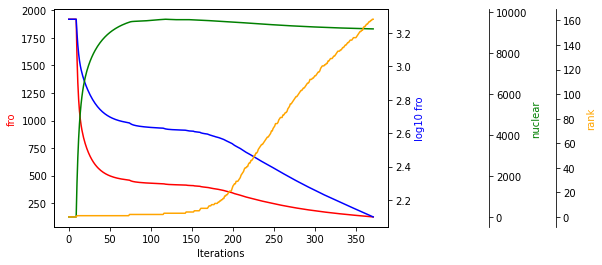

time elasped:  1147  s
-------------------------- Validating the training with data  0  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228521  Ratio:  0.7475408656283836  Off by one:  304625  Ratio:  0.9964932596656166  L2: 0.07393129736352762
Validation with other samples:
Sample size:  2751273  Correct:  713709  Ratio:  0.2594104619934118  Off by one:  1821146  Ratio:  0.6619284963724065  L2: 0.243158538651645
-------------------------- Running with data  1  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1921.2752275507016     nuc: 0.0      last rank: 0
fro:  1921.2752275507016     nuc: 0.0      last rank: 0
fro:  1921.2752275507016     nuc: 0.0      last rank: 0
fro:  1921.2752275507016     nuc: 0.0      last rank: 0
fro:  1921.2752275507016     nuc: 0.0      last rank: 0
fro:  1921.2752275507016     nuc: 0.0      last rank: 0
fro:  1921.2752275507016     nuc: 0.0      last rank: 0
fro:  1921.2752275507016     nuc: 0.

fro:  427.9954675220776     nuc: 9623.503260634468      last rank: 2
fro:  427.743283578271     nuc: 9626.875835874318      last rank: 2
fro:  427.49873844327186     nuc: 9630.235307862247      last rank: 2
fro:  427.26165839976215     nuc: 9633.581162806175      last rank: 2
fro:  427.03189068722077     nuc: 9636.913141299843      last rank: 2
fro:  426.8093027032352     nuc: 9640.2312271271      last rank: 2
fro:  424.9531869664762     nuc: 9643.53564226113      last rank: 3
fro:  423.36873840055904     nuc: 9644.96478641032      last rank: 3
fro:  422.1944062383366     nuc: 9644.837386588213      last rank: 3
fro:  421.29760796298865     nuc: 9643.693909066798      last rank: 3
fro:  420.59102129704326     nuc: 9641.927455057703      last rank: 3
fro:  420.0168597119838     nuc: 9639.820494191968      last rank: 3
fro:  419.53659201186144     nuc: 9637.572969283698      last rank: 3
fro:  419.1242641016818     nuc: 9635.323670594007      last rank: 3
fro:  418.76217282826667     nuc

fro:  280.30734386480566     nuc: 9428.628777772046      last rank: 53
fro:  278.28775759245406     nuc: 9425.837190334623      last rank: 54
fro:  276.41190376287767     nuc: 9423.028846525707      last rank: 55
fro:  274.37927263557367     nuc: 9420.272150958412      last rank: 57
fro:  272.45727814188444     nuc: 9417.478065490224      last rank: 57
fro:  270.6334172002267     nuc: 9414.703894721559      last rank: 58
fro:  268.7677001364922     nuc: 9411.978220784858      last rank: 59
fro:  267.18528931978227     nuc: 9409.267713651247      last rank: 59
fro:  265.38644183074     nuc: 9406.678310185082      last rank: 62
fro:  263.4777847083087     nuc: 9404.063846661647      last rank: 62
fro:  261.72789727129555     nuc: 9401.375822175247      last rank: 63
fro:  260.0094947754586     nuc: 9398.73191539539      last rank: 64
fro:  258.26441914273545     nuc: 9396.12654819616      last rank: 65
fro:  256.5551424496588     nuc: 9393.54140208098      last rank: 66
fro:  254.9748112

fro:  141.32126768830872     nuc: 9201.681201674146      last rank: 147
fro:  140.60105382660234     nuc: 9200.472610651326      last rank: 147
fro:  139.88493570654154     nuc: 9199.29931078953      last rank: 148
fro:  139.15363689581918     nuc: 9198.138608992496      last rank: 149
fro:  138.44858788615602     nuc: 9196.97494492527      last rank: 149
fro:  137.79179798335426     nuc: 9195.82851498533      last rank: 149
fro:  137.1391971320427     nuc: 9194.71539528538      last rank: 150
fro:  136.4705978219175     nuc: 9193.614191985173      last rank: 151
fro:  135.79507566129666     nuc: 9192.510333424256      last rank: 151
fro:  135.1631171372223     nuc: 9191.40837076255      last rank: 151
fro:  134.492492604448     nuc: 9190.33788491663      last rank: 153
fro:  133.79960878092558     nuc: 9189.256031133544      last rank: 153
fro:  133.1252111031025     nuc: 9188.166000930913      last rank: 154
fro:  132.48437237834088     nuc: 9187.088078544803      last rank: 154
fro:

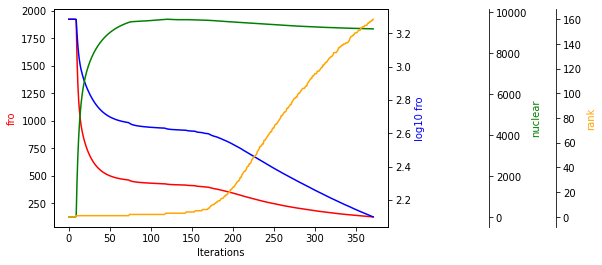

time elasped:  1277  s
-------------------------- Validating the training with data  1  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  229150  Ratio:  0.7495984586044351  Off by one:  304593  Ratio:  0.9963885808496649  L2: 0.07360070221554774
Validation with other samples:
Sample size:  2751273  Correct:  713864  Ratio:  0.25946679955060803  Off by one:  1820708  Ratio:  0.6617692973398133  L2: 0.24336099232943284
-------------------------- Running with data  2  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1920.3300497570724     nuc: 0.0      last rank: 0
fro:  1920.3300497570724     nuc: 0.0      last rank: 0
fro:  1920.3300497570724     nuc: 0.0      last rank: 0
fro:  1920.3300497570724     nuc: 0.0      last rank: 0
fro:  1920.3300497570724     nuc: 0.0      last rank: 0
fro:  1920.3300497570724     nuc: 0.0      last rank: 0
fro:  1920.3300497570724     nuc: 0.0      last rank: 0
fro:  1920.3300497570724     nuc:

fro:  425.7294716079789     nuc: 9625.674940583165      last rank: 2
fro:  425.4981697652042     nuc: 9629.057130315148      last rank: 2
fro:  425.27442198690716     nuc: 9632.418754974551      last rank: 2
fro:  425.0580228625127     nuc: 9635.759227947787      last rank: 2
fro:  423.2871631244396     nuc: 9639.07820649353      last rank: 3
fro:  421.7260464512908     nuc: 9640.565505689745      last rank: 3
fro:  420.556587090181     nuc: 9640.479582968881      last rank: 3
fro:  419.65477675820927     nuc: 9639.354239619817      last rank: 3
fro:  418.93827834385365     nuc: 9637.580558044396      last rank: 3
fro:  418.35214258880205     nuc: 9635.441862413201      last rank: 3
fro:  417.8594135225896     nuc: 9633.140591418294      last rank: 3
fro:  417.4349825634338     nuc: 9630.818840532535      last rank: 3
fro:  417.06157656980673     nuc: 9628.573986611602      last rank: 3
fro:  416.7271380564307     nuc: 9626.470516363184      last rank: 3
fro:  416.4231104593545     nuc

fro:  278.0671418663945     nuc: 9415.184924981862      last rank: 54
fro:  276.21384505921054     nuc: 9412.430152183697      last rank: 54
fro:  274.5585649191613     nuc: 9409.680192614913      last rank: 55
fro:  272.78554849577387     nuc: 9407.015023288652      last rank: 56
fro:  270.912082450711     nuc: 9404.345890292629      last rank: 58
fro:  269.14562529048555     nuc: 9401.659088372926      last rank: 58
fro:  267.4950520257844     nuc: 9399.001841205223      last rank: 59
fro:  265.93260418602523     nuc: 9396.402598247572      last rank: 60
fro:  264.2227651593125     nuc: 9393.86553547117      last rank: 61
fro:  262.6715643260573     nuc: 9391.291226088135      last rank: 61
fro:  261.11525278378605     nuc: 9388.765932767612      last rank: 62
fro:  259.1983191549622     nuc: 9386.260955428053      last rank: 65
fro:  257.3792073893704     nuc: 9383.617373820787      last rank: 65
fro:  255.84425049290036     nuc: 9380.950126525408      last rank: 66
fro:  254.115154

fro:  141.59634648114294     nuc: 9195.087832146237      last rank: 146
fro:  140.86440281380212     nuc: 9193.912974126517      last rank: 147
fro:  140.12253688021326     nuc: 9192.760536153004      last rank: 147
fro:  139.40816502106716     nuc: 9191.61262143444      last rank: 148
fro:  138.70910250145965     nuc: 9190.488552898008      last rank: 148
fro:  138.02740975710782     nuc: 9189.380910495274      last rank: 149
fro:  137.34886928826893     nuc: 9188.293464480525      last rank: 149
fro:  136.69154888687237     nuc: 9187.216264828316      last rank: 150
fro:  136.03113351654093     nuc: 9186.158228339158      last rank: 150
fro:  135.3595283250505     nuc: 9185.101506197723      last rank: 151
fro:  134.70404676268856     nuc: 9184.04319482475      last rank: 152
fro:  133.98798193595812     nuc: 9182.996391884812      last rank: 153
fro:  133.32159563354804     nuc: 9181.92159306198      last rank: 153
fro:  132.69305988672775     nuc: 9180.877972362556      last rank: 

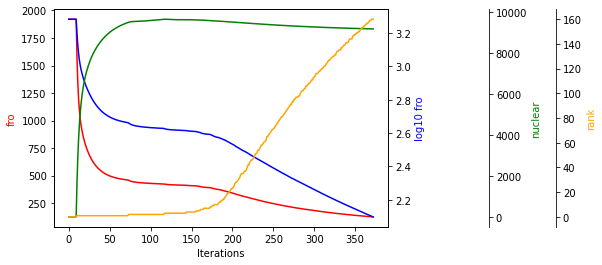

time elasped:  1268  s
-------------------------- Validating the training with data  2  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228736  Ratio:  0.7482441764230594  Off by one:  304598  Ratio:  0.9964049369146574  L2: 0.07381807263880448
Validation with other samples:
Sample size:  2751273  Correct:  717008  Ratio:  0.26060954329141456  Off by one:  1824257  Ratio:  0.6630592456655519  L2: 0.2429075701845212
-------------------------- Running with data  3  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1921.0852401702534     nuc: 0.0      last rank: 0
fro:  1921.0852401702534     nuc: 0.0      last rank: 0
fro:  1921.0852401702534     nuc: 0.0      last rank: 0
fro:  1921.0852401702534     nuc: 0.0      last rank: 0
fro:  1921.0852401702534     nuc: 0.0      last rank: 0
fro:  1921.0852401702534     nuc: 0.0      last rank: 0
fro:  1921.0852401702534     nuc: 0.0      last rank: 0
fro:  1921.0852401702534     nuc: 

fro:  427.4378977525878     nuc: 9627.998208693924      last rank: 2
fro:  427.2077383530278     nuc: 9631.394678175111      last rank: 2
fro:  426.9856677146732     nuc: 9634.779609285455      last rank: 2
fro:  426.1043120718875     nuc: 9638.151927671886      last rank: 3
fro:  424.2473658815447     nuc: 9640.779297049332      last rank: 3
fro:  422.907681769114     nuc: 9641.481652382641      last rank: 3
fro:  421.91201105655995     nuc: 9640.908688082814      last rank: 3
fro:  421.14754666641625     nuc: 9639.532383434318      last rank: 3
fro:  420.54066694527717     nuc: 9637.69156020167      last rank: 3
fro:  420.0430554301065     nuc: 9635.625962092028      last rank: 3
fro:  419.6227313357757     nuc: 9633.502135197388      last rank: 3
fro:  419.2582864058283     nuc: 9631.432958246722      last rank: 3
fro:  418.93519001550663     nuc: 9629.49229558908      last rank: 3
fro:  418.64341887599284     nuc: 9627.725930228222      last rank: 3
fro:  418.37593204247037     nuc

fro:  277.3403623038212     nuc: 9425.310640239088      last rank: 54
fro:  275.49137390022946     nuc: 9422.551385141378      last rank: 56
fro:  273.7104897894421     nuc: 9419.793379741088      last rank: 57
fro:  271.96443271441234     nuc: 9417.054654772252      last rank: 57
fro:  270.3579710142082     nuc: 9414.335269315638      last rank: 58
fro:  268.5148624135666     nuc: 9411.70005878638      last rank: 59
fro:  266.71104115437487     nuc: 9409.01462689969      last rank: 61
fro:  264.88371221782     nuc: 9406.34183257497      last rank: 61
fro:  263.08326251958295     nuc: 9403.657491927232      last rank: 63
fro:  261.2698898777187     nuc: 9400.995118929797      last rank: 63
fro:  259.4653564267847     nuc: 9398.337982955814      last rank: 65
fro:  257.5611814936246     nuc: 9395.697226709479      last rank: 66
fro:  255.70242026395132     nuc: 9393.007357551316      last rank: 67
fro:  253.93033633444614     nuc: 9390.312416608802      last rank: 69
fro:  252.170070316

fro:  140.56582905528893     nuc: 9203.827145101775      last rank: 147
fro:  139.88941669311006     nuc: 9202.658969144573      last rank: 147
fro:  139.19818163826577     nuc: 9201.526454459294      last rank: 148
fro:  138.5122071032968     nuc: 9200.396779415194      last rank: 149
fro:  137.8123901344083     nuc: 9199.276265380173      last rank: 149
fro:  137.09106467433043     nuc: 9198.155874468073      last rank: 150
fro:  136.375276339547     nuc: 9197.03252702262      last rank: 151
fro:  135.6460729739763     nuc: 9195.919526411599      last rank: 153
fro:  134.92578871303346     nuc: 9194.802547377625      last rank: 153
fro:  134.24617608429236     nuc: 9193.692918448018      last rank: 154
fro:  133.57101774284655     nuc: 9192.61538112933      last rank: 154
fro:  132.9430835267142     nuc: 9191.549899594382      last rank: 154
fro:  132.28322356855998     nuc: 9190.519977287731      last rank: 155
fro:  131.65552439501047     nuc: 9189.488488822692      last rank: 156


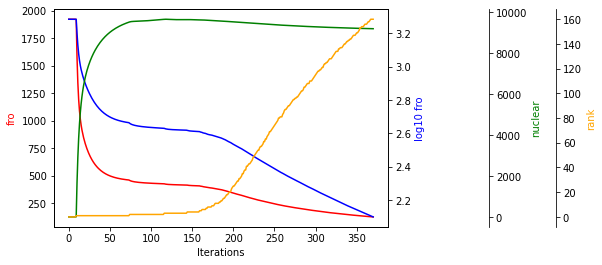

time elasped:  1257  s
-------------------------- Validating the training with data  3  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228690  Ratio:  0.7480937006251288  Off by one:  304619  Ratio:  0.9964736323876257  L2: 0.07377987589378543
Validation with other samples:
Sample size:  2751273  Correct:  714218  Ratio:  0.25959546726188204  Off by one:  1821668  Ratio:  0.662118226726319  L2: 0.24333861305269597
-------------------------- Running with data  4  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1921.039497251423     nuc: 0.0      last rank: 0
fro:  1921.039497251423     nuc: 0.0      last rank: 0
fro:  1921.039497251423     nuc: 0.0      last rank: 0
fro:  1921.039497251423     nuc: 0.0      last rank: 0
fro:  1921.039497251423     nuc: 0.0      last rank: 0
fro:  1921.039497251423     nuc: 0.0      last rank: 0
fro:  1921.039497251423     nuc: 0.0      last rank: 0
fro:  1921.039497251423     nuc: 0.0     

fro:  428.58102286772163     nuc: 9621.010590631497      last rank: 2
fro:  428.3380211606133     nuc: 9624.631624367485      last rank: 2
fro:  427.0145642109145     nuc: 9628.244311726055      last rank: 3
fro:  425.3099125199723     nuc: 9630.586269223546      last rank: 3
fro:  424.05430633922305     nuc: 9631.153394324629      last rank: 3
fro:  423.1022405047547     nuc: 9630.537635623241      last rank: 3
fro:  422.3577458337971     nuc: 9629.171729141646      last rank: 3
fro:  421.75728202744637     nuc: 9627.368578206864      last rank: 3
fro:  421.25850085077775     nuc: 9625.35143747972      last rank: 3
fro:  420.83291865315     nuc: 9623.276912911391      last rank: 3
fro:  420.46115489314457     nuc: 9621.252395265314      last rank: 3
fro:  420.12984012545627     nuc: 9619.34920981837      last rank: 3
fro:  419.8296048460835     nuc: 9617.612488170606      last rank: 3
fro:  419.5537667031381     nuc: 9616.068544313173      last rank: 3
fro:  419.2974690180128     nuc:

fro:  276.31519641336354     nuc: 9417.458678428524      last rank: 56
fro:  274.5465493948852     nuc: 9414.78445602904      last rank: 58
fro:  272.530773153647     nuc: 9412.138596664077      last rank: 58
fro:  270.781109695712     nuc: 9409.411514078805      last rank: 59
fro:  269.1080268977269     nuc: 9406.764103504105      last rank: 59
fro:  267.3429613425497     nuc: 9404.174398951414      last rank: 61
fro:  265.6116994944315     nuc: 9401.579250710252      last rank: 62
fro:  263.8587433617413     nuc: 9398.997626549954      last rank: 62
fro:  262.2543943413865     nuc: 9396.40671421836      last rank: 63
fro:  260.73008803505104     nuc: 9393.870119411997      last rank: 63
fro:  259.0874553569873     nuc: 9391.382051615321      last rank: 65
fro:  257.25295828081084     nuc: 9388.872784404593      last rank: 66
fro:  255.47048078798602     nuc: 9386.272456263585      last rank: 68
fro:  253.6704673100211     nuc: 9383.661700654746      last rank: 69
fro:  251.9604356352

fro:  141.0205610987308     nuc: 9199.506356062186      last rank: 147
fro:  140.29694796629602     nuc: 9198.375123785056      last rank: 148
fro:  139.6000839514818     nuc: 9197.259977133792      last rank: 148
fro:  138.94714459432757     nuc: 9196.16495184401      last rank: 148
fro:  138.3189524577412     nuc: 9195.101759603614      last rank: 149
fro:  137.5872810516879     nuc: 9194.06113496474      last rank: 150
fro:  136.90849532332965     nuc: 9192.974067784613      last rank: 151
fro:  136.2124553448162     nuc: 9191.917754943825      last rank: 151
fro:  135.56697024070985     nuc: 9190.855454964974      last rank: 151
fro:  134.87425153394113     nuc: 9189.823784929067      last rank: 153
fro:  134.1722257850279     nuc: 9188.7720099158      last rank: 153
fro:  133.52554148142332     nuc: 9187.715259481374      last rank: 153
fro:  132.8682469351824     nuc: 9186.689849621212      last rank: 154
fro:  132.23138535741012     nuc: 9185.66629524605      last rank: 154
fro:

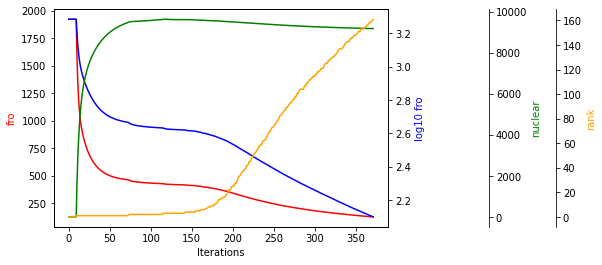

time elasped:  1188  s
-------------------------- Validating the training with data  4  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228777  Ratio:  0.7483782961559976  Off by one:  304625  Ratio:  0.9964932596656166  L2: 0.07374168462265589
Validation with other samples:
Sample size:  2751273  Correct:  715185  Ratio:  0.25994694092516446  Off by one:  1822924  Ratio:  0.6625747426736641  L2: 0.24317195649953435
-------------------------- Running with data  5  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1919.8977837374573     nuc: 0.0      last rank: 0
fro:  1919.8977837374573     nuc: 0.0      last rank: 0
fro:  1919.8977837374573     nuc: 0.0      last rank: 0
fro:  1919.8977837374573     nuc: 0.0      last rank: 0
fro:  1919.8977837374573     nuc: 0.0      last rank: 0
fro:  1919.8977837374573     nuc: 0.0      last rank: 0
fro:  1919.8977837374573     nuc: 0.0      last rank: 0
fro:  1919.8977837374573     nuc:

fro:  427.66011117126016     nuc: 9623.224110020776      last rank: 2
fro:  427.4224238118733     nuc: 9626.536025984598      last rank: 2
fro:  427.1924848040451     nuc: 9629.83504298322      last rank: 2
fro:  426.9700845021597     nuc: 9633.120212940634      last rank: 2
fro:  426.75502988366003     nuc: 9636.390801981      last rank: 2
fro:  426.18460011852767     nuc: 9639.646277237785      last rank: 3
fro:  424.31427873340544     nuc: 9642.477540701395      last rank: 3
fro:  422.95074373003     nuc: 9643.28635595144      last rank: 3
fro:  421.92784279122293     nuc: 9642.730482766296      last rank: 3
fro:  421.13635030287514     nuc: 9641.293083103803      last rank: 3
fro:  420.5042724268097     nuc: 9639.325353043048      last rank: 3
fro:  419.98388782072635     nuc: 9637.079372682285      last rank: 3
fro:  419.54329915888167     nuc: 9634.733252614049      last rank: 3
fro:  419.16095272214466     nuc: 9632.410271688197      last rank: 3
fro:  418.82208965822485     nuc

fro:  278.48156909049044     nuc: 9420.341536841104      last rank: 54
fro:  276.7706236411443     nuc: 9417.811186313134      last rank: 54
fro:  275.08373052075484     nuc: 9415.317231924837      last rank: 55
fro:  273.08547633683435     nuc: 9412.849538762272      last rank: 58
fro:  271.03248115039463     nuc: 9410.282997241979      last rank: 58
fro:  269.23801562304857     nuc: 9407.636768805714      last rank: 59
fro:  267.59976666106076     nuc: 9405.053952382143      last rank: 59
fro:  265.9565211427028     nuc: 9402.549466016968      last rank: 60
fro:  264.3900543116274     nuc: 9400.073376139822      last rank: 61
fro:  262.71669202713036     nuc: 9397.654413719538      last rank: 62
fro:  261.1539280313586     nuc: 9395.222935724363      last rank: 63
fro:  259.33309641000125     nuc: 9392.840162059667      last rank: 65
fro:  257.628438380144     nuc: 9390.379535429649      last rank: 65
fro:  255.95401640980376     nuc: 9387.93035460102      last rank: 67
fro:  254.211

fro:  141.10622491416706     nuc: 9203.887519750431      last rank: 146
fro:  140.447191151048     nuc: 9202.740178085354      last rank: 147
fro:  139.70491319519908     nuc: 9201.619468098135      last rank: 148
fro:  138.98727917945516     nuc: 9200.462174122786      last rank: 149
fro:  138.26331613105447     nuc: 9199.318544539925      last rank: 150
fro:  137.5391372055669     nuc: 9198.174747113964      last rank: 150
fro:  136.8729586482206     nuc: 9197.034496513952      last rank: 150
fro:  136.24458155706142     nuc: 9195.931587540545      last rank: 150
fro:  135.60973361989156     nuc: 9194.858458077419      last rank: 151
fro:  134.9687579718691     nuc: 9193.792405226883      last rank: 151
fro:  134.35005091163598     nuc: 9192.728613173294      last rank: 152
fro:  133.7084766727785     nuc: 9191.682921641244      last rank: 152
fro:  133.10400630466918     nuc: 9190.626898720606      last rank: 152
fro:  132.50145450811257     nuc: 9189.595000145335      last rank: 15

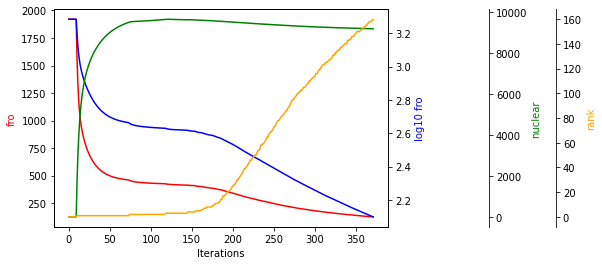

time elasped:  1330  s
-------------------------- Validating the training with data  5  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228580  Ratio:  0.7477338671952947  Off by one:  304582  Ratio:  0.9963525975066815  L2: 0.07392833067858155
Validation with other samples:
Sample size:  2751273  Correct:  714725  Ratio:  0.2597797455941304  Off by one:  1820594  Ratio:  0.6617278619751656  L2: 0.24322352621401652
-------------------------- Running with data  6  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1921.1452313659163     nuc: 0.0      last rank: 0
fro:  1921.1452313659163     nuc: 0.0      last rank: 0
fro:  1921.1452313659163     nuc: 0.0      last rank: 0
fro:  1921.1452313659163     nuc: 0.0      last rank: 0
fro:  1921.1452313659163     nuc: 0.0      last rank: 0
fro:  1921.1452313659163     nuc: 0.0      last rank: 0
fro:  1921.1452313659163     nuc: 0.0      last rank: 0
fro:  1921.1452313659163     nuc: 

fro:  427.13290177363587     nuc: 9634.437552008916      last rank: 2
fro:  426.8938369364222     nuc: 9637.943042547558      last rank: 2
fro:  426.66284931095373     nuc: 9641.435227364113      last rank: 2
fro:  426.439739048305     nuc: 9644.913078348884      last rank: 2
fro:  424.9581226547767     nuc: 9648.375824548006      last rank: 3
fro:  423.3211512861088     nuc: 9650.392320126048      last rank: 3
fro:  422.1251582286035     nuc: 9650.745209869245      last rank: 3
fro:  421.2244192382191     nuc: 9650.002786407189      last rank: 3
fro:  420.52348599237183     nuc: 9648.577985453601      last rank: 3
fro:  419.95968485386055     nuc: 9646.767274375652      last rank: 3
fro:  419.4916349295204     nuc: 9644.780388797917      last rank: 3
fro:  419.09178501588076     nuc: 9642.76292421178      last rank: 3
fro:  418.7415880438782     nuc: 9640.813399162664      last rank: 3
fro:  418.42838751856175     nuc: 9638.996072531867      last rank: 3
fro:  418.14340780082716     n

fro:  277.86794870167023     nuc: 9432.429651245206      last rank: 54
fro:  276.0749663265397     nuc: 9429.793567511268      last rank: 55
fro:  274.2373933798843     nuc: 9427.175391511195      last rank: 57
fro:  272.33742209646044     nuc: 9424.540224798991      last rank: 57
fro:  270.52413710615116     nuc: 9421.866008441735      last rank: 58
fro:  268.89208135449843     nuc: 9419.209617729088      last rank: 59
fro:  267.1166175763952     nuc: 9416.640489827842      last rank: 60
fro:  265.287795776287     nuc: 9414.058135148662      last rank: 62
fro:  263.39512130728326     nuc: 9411.470642768738      last rank: 63
fro:  261.60482092499603     nuc: 9408.866750105743      last rank: 63
fro:  259.79290661281436     nuc: 9406.293985716296      last rank: 65
fro:  257.97742862270127     nuc: 9403.724257463928      last rank: 66
fro:  256.31191006371745     nuc: 9401.13531520878      last rank: 67
fro:  254.6490427561788     nuc: 9398.596617180548      last rank: 67
fro:  253.213

fro:  141.1370610970625     nuc: 9212.51103924793      last rank: 147
fro:  140.4133134989024     nuc: 9211.311606768526      last rank: 148
fro:  139.67737528520593     nuc: 9210.150524226887      last rank: 149
fro:  138.92554532742514     nuc: 9208.988979406226      last rank: 149
fro:  138.23825680220185     nuc: 9207.827937056943      last rank: 149
fro:  137.57197255027404     nuc: 9206.706539227183      last rank: 150
fro:  136.87180665969314     nuc: 9205.604923611761      last rank: 151
fro:  136.18958510396843     nuc: 9204.488428612021      last rank: 151
fro:  135.54612264268675     nuc: 9203.383316531897      last rank: 152
fro:  134.87386008279066     nuc: 9202.306259928038      last rank: 153
fro:  134.1585549785212     nuc: 9201.219183253324      last rank: 154
fro:  133.4612886180812     nuc: 9200.11402811154      last rank: 154
fro:  132.80801706041666     nuc: 9199.024222001677      last rank: 155
fro:  132.14060043088557     nuc: 9197.96625424147      last rank: 155

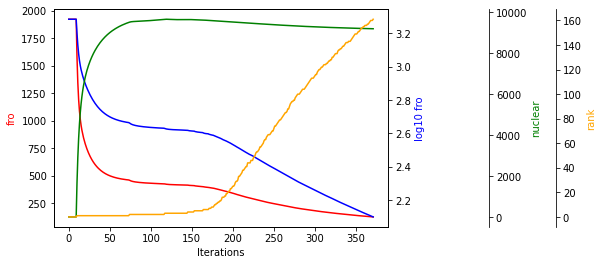

time elasped:  1148  s
-------------------------- Validating the training with data  6  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228982  Ratio:  0.7490488948206885  Off by one:  304607  Ratio:  0.9964343778316438  L2: 0.07367927466576077
Validation with other samples:
Sample size:  2751273  Correct:  716137  Ratio:  0.26029296256678275  Off by one:  1823669  Ratio:  0.6628455264163171  L2: 0.24291164877102406
-------------------------- Running with data  7  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1920.0063801977326     nuc: 0.0      last rank: 0
fro:  1920.0063801977326     nuc: 0.0      last rank: 0
fro:  1920.0063801977326     nuc: 0.0      last rank: 0
fro:  1920.0063801977326     nuc: 0.0      last rank: 0
fro:  1920.0063801977326     nuc: 0.0      last rank: 0
fro:  1920.0063801977326     nuc: 0.0      last rank: 0
fro:  1920.0063801977326     nuc: 0.0      last rank: 0
fro:  1920.0063801977326     nuc:

fro:  428.35478859205654     nuc: 9624.834438307633      last rank: 2
fro:  428.11170361536387     nuc: 9628.384774784965      last rank: 2
fro:  427.8767152599775     nuc: 9631.926203513438      last rank: 2
fro:  426.31418308792064     nuc: 9635.4580762945      last rank: 3
fro:  424.62592890580345     nuc: 9637.485457371618      last rank: 3
fro:  423.3870836093639     nuc: 9637.821592386805      last rank: 3
fro:  422.45046886340435     nuc: 9637.034789508802      last rank: 3
fro:  421.71957884043127     nuc: 9635.539946296623      last rank: 3
fro:  421.1308776432763     nuc: 9633.636588771024      last rank: 3
fro:  420.6422454841363     nuc: 9631.538007379051      last rank: 3
fro:  420.22549206525696     nuc: 9629.393441651711      last rank: 3
fro:  419.8615217977902     nuc: 9627.304882403248      last rank: 3
fro:  419.5372130823855     nuc: 9625.33973462574      last rank: 3
fro:  419.24340028457     nuc: 9623.54031534775      last rank: 3
fro:  418.97356379852846     nuc:

fro:  276.8483319770706     nuc: 9422.130806035872      last rank: 55
fro:  275.2687190592508     nuc: 9419.595163294896      last rank: 56
fro:  273.5249036422914     nuc: 9417.134812823311      last rank: 57
fro:  271.8731113851526     nuc: 9414.647935360565      last rank: 58
fro:  270.0702148180463     nuc: 9412.191886459983      last rank: 59
fro:  268.2767359354611     nuc: 9409.685540556795      last rank: 60
fro:  266.4346568495705     nuc: 9407.16381629795      last rank: 61
fro:  264.6694380784722     nuc: 9404.629125307922      last rank: 62
fro:  262.7833946919626     nuc: 9402.127112249636      last rank: 64
fro:  261.02959461315504     nuc: 9399.577406817818      last rank: 64
fro:  259.2827881987824     nuc: 9397.047686755279      last rank: 66
fro:  257.54705286073136     nuc: 9394.51813733111      last rank: 66
fro:  255.83222909337158     nuc: 9391.982169348754      last rank: 67
fro:  254.12359218039992     nuc: 9389.445793182218      last rank: 69
fro:  252.41405166

fro:  140.5925419251062     nuc: 9204.603758371515      last rank: 148
fro:  139.89927196534467     nuc: 9203.446002003719      last rank: 148
fro:  139.24800146211078     nuc: 9202.331025291274      last rank: 148
fro:  138.61837952058517     nuc: 9201.24884437412      last rank: 149
fro:  137.94044975849138     nuc: 9200.188492546484      last rank: 150
fro:  137.25519493497575     nuc: 9199.108626972255      last rank: 150
fro:  136.54771653847888     nuc: 9198.027334201397      last rank: 151
fro:  135.8601889668706     nuc: 9196.93912293638      last rank: 152
fro:  135.1886871758478     nuc: 9195.86671859969      last rank: 152
fro:  134.5605538459298     nuc: 9194.807355187248      last rank: 152
fro:  133.91886239667798     nuc: 9193.778487465468      last rank: 153
fro:  133.2914823161219     nuc: 9192.75066028355      last rank: 153
fro:  132.61304097612697     nuc: 9191.73481778648      last rank: 155
fro:  131.9348410080915     nuc: 9190.702177583578      last rank: 155
fro

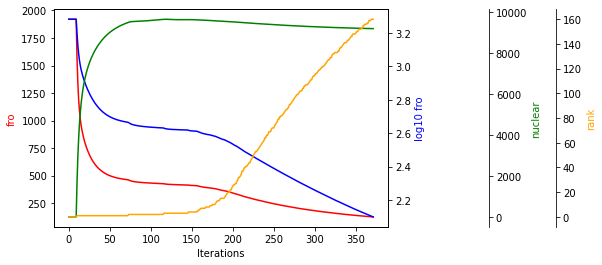

time elasped:  1233  s
-------------------------- Validating the training with data  7  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228614  Ratio:  0.7478450884372434  Off by one:  304636  Ratio:  0.9965292430086  L2: 0.07382455090545384
Validation with other samples:
Sample size:  2751273  Correct:  713703  Ratio:  0.2594082811847461  Off by one:  1821318  Ratio:  0.6619910128874888  L2: 0.24295084134623454
-------------------------- Running with data  8  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1920.48542040808     nuc: 0.0      last rank: 0
fro:  1920.48542040808     nuc: 0.0      last rank: 0
fro:  1920.48542040808     nuc: 0.0      last rank: 0
fro:  1920.48542040808     nuc: 0.0      last rank: 0
fro:  1920.48542040808     nuc: 0.0      last rank: 0
fro:  1920.48542040808     nuc: 0.0      last rank: 0
fro:  1920.48542040808     nuc: 0.0      last rank: 0
fro:  1920.48542040808     nuc: 0.0      last rank:

fro:  426.4293673925652     nuc: 9634.780290740444      last rank: 2
fro:  426.19250874387626     nuc: 9638.286158338717      last rank: 2
fro:  425.8467996917109     nuc: 9641.778073088084      last rank: 3
fro:  423.9931884584468     nuc: 9645.115003372619      last rank: 3
fro:  422.6275231021454     nuc: 9646.333547194215      last rank: 3
fro:  421.59085569551365     nuc: 9646.102407916627      last rank: 3
fro:  420.77883183180154     nuc: 9644.91526044645      last rank: 3
fro:  420.1226267517892     nuc: 9643.133250820356      last rank: 3
fro:  419.5765115062816     nuc: 9641.017739968858      last rank: 3
fro:  419.10979717710586     nuc: 9638.755379479015      last rank: 3
fro:  418.7016302972467     nuc: 9636.477214428956      last rank: 3
fro:  418.3376301843639     nuc: 9634.273167453786      last rank: 3
fro:  418.0077113148786     nuc: 9632.202972619383      last rank: 3
fro:  417.7046671835179     nuc: 9630.304394318271      last rank: 3
fro:  417.42324393136306     nu

fro:  277.28819876587056     nuc: 9421.3155244005      last rank: 54
fro:  275.377862937278     nuc: 9418.76502890564      last rank: 55
fro:  273.7391101923576     nuc: 9416.183336096736      last rank: 55
fro:  271.8144036501325     nuc: 9413.703697484569      last rank: 57
fro:  270.1181899817225     nuc: 9411.15165487455      last rank: 58
fro:  268.4139773549301     nuc: 9408.657290123738      last rank: 58
fro:  266.5456533175208     nuc: 9406.17674755352      last rank: 60
fro:  264.7424142478831     nuc: 9403.651191880304      last rank: 61
fro:  262.9691344992489     nuc: 9401.133868481891      last rank: 62
fro:  261.3794353229945     nuc: 9398.630692439081      last rank: 62
fro:  259.8494165183251     nuc: 9396.203167272179      last rank: 63
fro:  258.3486869464709     nuc: 9393.840215371849      last rank: 64
fro:  256.8058921656866     nuc: 9391.52050711069      last rank: 65
fro:  255.22266751338137     nuc: 9389.19895870256      last rank: 66
fro:  253.68606315729866  

fro:  141.09589339405167     nuc: 9208.615777517312      last rank: 147
fro:  140.4020879624723     nuc: 9207.432052042743      last rank: 148
fro:  139.70308435204865     nuc: 9206.283832699373      last rank: 148
fro:  138.9956418093195     nuc: 9205.139019079179      last rank: 149
fro:  138.31202996447993     nuc: 9204.004432424368      last rank: 149
fro:  137.6494725473408     nuc: 9202.890741114436      last rank: 150
fro:  136.98027428304496     nuc: 9201.79601743854      last rank: 150
fro:  136.2886593420193     nuc: 9200.701538962872      last rank: 151
fro:  135.64159103731626     nuc: 9199.601979736162      last rank: 152
fro:  134.96071723204932     nuc: 9198.531375400165      last rank: 152
fro:  134.2926990987274     nuc: 9197.44523031055      last rank: 153
fro:  133.64501713323335     nuc: 9196.366220768792      last rank: 153
fro:  132.968402347793     nuc: 9195.299341630765      last rank: 154
fro:  132.33539327676257     nuc: 9194.221002766095      last rank: 155
f

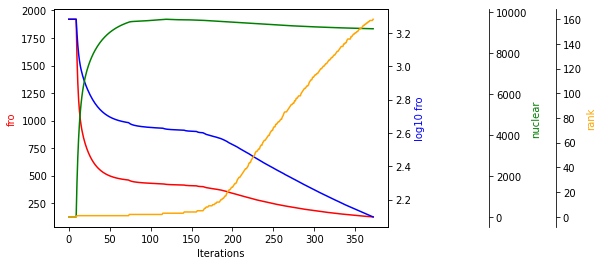

time elasped:  1220  s
-------------------------- Validating the training with data  8  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  229235  Ratio:  0.7498765117093069  Off by one:  304650  Ratio:  0.996575039990579  L2: 0.07351304832649512
Validation with other samples:
Sample size:  2751273  Correct:  715836  Ratio:  0.2601835586653887  Off by one:  1824360  Ratio:  0.6630966828809791  L2: 0.24280824442325757
-------------------------- Running with data  9  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1920.4293790712534     nuc: 0.0      last rank: 0
fro:  1920.4293790712534     nuc: 0.0      last rank: 0
fro:  1920.4293790712534     nuc: 0.0      last rank: 0
fro:  1920.4293790712534     nuc: 0.0      last rank: 0
fro:  1920.4293790712534     nuc: 0.0      last rank: 0
fro:  1920.4293790712534     nuc: 0.0      last rank: 0
fro:  1920.4293790712534     nuc: 0.0      last rank: 0
fro:  1920.4293790712534     nuc: 0

fro:  427.9068221717567     nuc: 9612.38762435961      last rank: 2
fro:  427.6577853935834     nuc: 9615.956202515816      last rank: 2
fro:  427.41660687680167     nuc: 9619.510483666778      last rank: 2
fro:  427.1830805463235     nuc: 9623.049595323813      last rank: 2
fro:  426.95701991482383     nuc: 9626.572901111496      last rank: 2
fro:  426.61207884637463     nuc: 9630.079987957237      last rank: 3
fro:  424.6506241947746     nuc: 9633.430860149037      last rank: 3
fro:  423.22968748332806     nuc: 9634.674136292291      last rank: 3
fro:  422.17047708169275     nuc: 9634.487621472843      last rank: 3
fro:  421.35588257810196     nuc: 9633.368857838239      last rank: 3
fro:  420.70901866488094     nuc: 9631.679390241374      last rank: 3
fro:  420.1791340178944     nuc: 9629.678802581151      last rank: 3
fro:  419.73244980630653     nuc: 9627.550714053315      last rank: 3
fro:  419.34623619917943     nuc: 9625.422518099542      last rank: 3
fro:  419.004990836102    

fro:  280.12974515570465     nuc: 9420.42682911668      last rank: 52
fro:  278.4376744299847     nuc: 9417.734732023338      last rank: 53
fro:  276.369098020803     nuc: 9415.108114622464      last rank: 55
fro:  274.56194681077915     nuc: 9412.365243325032      last rank: 55
fro:  272.6609578589566     nuc: 9409.674007760284      last rank: 57
fro:  270.6712513998945     nuc: 9406.971196644368      last rank: 58
fro:  268.7919866020692     nuc: 9404.220529314814      last rank: 59
fro:  267.1169805683775     nuc: 9401.484715254563      last rank: 59
fro:  265.3411181170444     nuc: 9398.830316919812      last rank: 61
fro:  263.3821528852486     nuc: 9396.170816875256      last rank: 62
fro:  261.5388930413862     nuc: 9393.42492755004      last rank: 63
fro:  259.8385466465988     nuc: 9390.705822234217      last rank: 64
fro:  258.27056448690126     nuc: 9388.064676696391      last rank: 65
fro:  256.590338167071     nuc: 9385.516226010703      last rank: 66
fro:  254.85997017680

fro:  141.4945814349142     nuc: 9198.246013789565      last rank: 145
fro:  140.786115447864     nuc: 9197.09904756772      last rank: 146
fro:  140.049837804012     nuc: 9195.941632595259      last rank: 147
fro:  139.31509844996586     nuc: 9194.77684121831      last rank: 148
fro:  138.61596131287692     nuc: 9193.617194636761      last rank: 148
fro:  137.89665754256148     nuc: 9192.479711017571      last rank: 150
fro:  137.1552812485293     nuc: 9191.338962733404      last rank: 150
fro:  136.43176510785554     nuc: 9190.187066476381      last rank: 151
fro:  135.7033116215318     nuc: 9189.047802094447      last rank: 152
fro:  135.02217318990003     nuc: 9187.91247976993      last rank: 152
fro:  134.38672313948308     nuc: 9186.809224268702      last rank: 152
fro:  133.72967169496852     nuc: 9185.741091182583      last rank: 153
fro:  133.10920469790875     nuc: 9184.670112999418      last rank: 153
fro:  132.4342148354247     nuc: 9183.628036974034      last rank: 155
fro

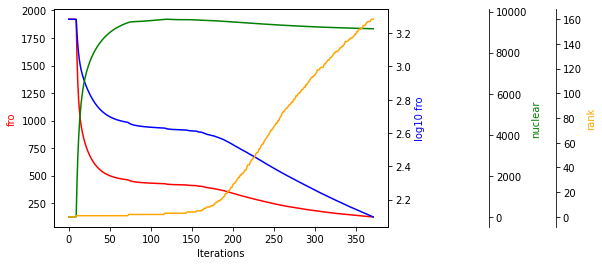

time elasped:  1190  s
-------------------------- Validating the training with data  9  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  229235  Ratio:  0.7498765117093069  Off by one:  304620  Ratio:  0.9964769036006241  L2: 0.07355069038178447
Validation with other samples:
Sample size:  2751273  Correct:  714008  Ratio:  0.2595191389585839  Off by one:  1821589  Ratio:  0.6620895127455545  L2: 0.2433876702504368
--------------------------------- Summary ---------------------------------
-------------------------- Data  0  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228521  Ratio:  0.7475408656283836  Off by one:  304625  Ratio:  0.9964932596656166  L2: 0.07393129736352762
Validation with other samples:
Sample size:  2751273  Correct:  713709  Ratio:  0.2594104619934118  Off by one:  1821146  Ratio:  0.6619284963724065  L2: 0.243158538651645
-------------------------- Data  1  -----------------

In [4]:
import svtcpu
import utils
import time
import scipy
import scipy.sparse
import scipy.sparse.linalg

# returns the size of the locations, the number of correct predicted values,
# the number of predicted values off by one (means off by 0.5 in ratings),
# and the Frobenius norm squared of the error matrix and original matrix on these locations
def validate_training_result(prediction, actual, locations):
    correct = 0
    off_by_one = 0
    for j in range(len(locations[0])):
        predicted_value = prediction[locations[0][j], locations[1][j]]
        actual_value = actual[locations[0][j], locations[1][j]]
        if predicted_value == actual_value:
            correct += 1
        if abs(predicted_value - actual_value) <= 1:
            off_by_one += 1
    difference = utils.filter_locations( (prediction - actual).astype(dtype="float32"), locations)
    fro_squared = scipy.sparse.linalg.norm(difference, ord='fro')
    fro_squared = fro_squared * fro_squared
    original_fro_squared = scipy.sparse.linalg.norm(utils.filter_locations(actual.astype("float32"), locations), ord='fro')
    original_fro_squared = original_fro_squared * original_fro_squared
    return len(locations[0]), correct, off_by_one, fro_squared, original_fro_squared

# obtain matrix with all the available data in 3000x3000 users and movies.
total_ratings_pivot = ratingsS.pivot(index = "userId", columns = "movieId", values = "rating")
total_ratings_matrix = total_ratings_pivot.to_numpy(copy=True, na_value = np.nan)
total_ratings_matrix_int = np.rint(total_ratings_matrix * 2).astype("int32")

# performance data for cross validation
train_total_no = []
train_correct = []
train_off_by_one = []
train_fro_norm_relative = []
valid_total_no = []
valid_correct = []
valid_off_by_one = []
valid_fro_norm_relative = []

# do cross validation here
for k in range(divisions):
    print("-------------------------- Running with data ", k, " --------------------------")
    print("Training:")
    movie_arr = ratingsSubsamplePivot[k].to_numpy(copy=True, na_value = np.nan)
    
    # obtain the locations of a subsample
    locations = ratingsSubsample[k][["uid_matrix","mid_matrix"]].to_numpy(dtype=int, copy=True).transpose()
    locations = locations.tolist()
    # convert to sparse matrix
    movie_arr = utils.filter_locations(movie_arr, locations) 
    
    # run SVT using the sparse matrix
    timems = time.time()
    result = svtcpu.svt_algorithm_small_step_size(movie_arr, locations, log=True, step_size = 4, tolerance = 125, tolerance_absolute = True) #, suggested_tau = 30000
    print("time elasped: ",int(time.time()-timems)," s")
    
    # predict using result
    predict = np.rint(result * 2) / 2.0
    predict = np.maximum(np.minimum(predict, 5.0), 1.0) # truncating if too large/small
    
    # validation step
    print("-------------------------- Validating the training with data ", k, " --------------------------")
    intpredict = (np.rint(predict * 2)).astype("int32")
    total_no, total_correct, total_off_by_one, total_fro_norm_sq, original_fro_norm_sq = validate_training_result(intpredict, total_ratings_matrix_int, locations)
    relative_fro_norm = math.sqrt(total_fro_norm_sq / original_fro_norm_sq)
    print("Validation with training sample:")
    print("Sample size: ", total_no, " Correct: ", total_correct, " Ratio: ", (total_correct+0.0)/total_no, " Off by one: ", total_off_by_one, " Ratio: ", (total_off_by_one+0.0)/total_no, " L2:", relative_fro_norm)
    train_total_no.append(total_no)
    train_correct.append(total_correct)
    train_off_by_one.append(total_off_by_one)
    train_fro_norm_relative.append(relative_fro_norm)
    
    print("Validation with other samples:")
    total_no = 0
    total_correct = 0
    total_off_by_one = 0
    total_fro_norm_sq = 0
    original_fro_norm_sq = 0
    for j in range(divisions):
        if j != k:
            jlocations = ratingsSubsample[j][["uid_matrix","mid_matrix"]].to_numpy(dtype=int, copy=True).transpose()
            jlocations = jlocations.tolist()

            jtotal_no, jtotal_correct, joff_by_one, jfro_norm_sq, joriginal_fro_norm = validate_training_result(intpredict, total_ratings_matrix_int, jlocations)
            total_no += jtotal_no
            total_correct += jtotal_correct
            total_off_by_one += joff_by_one
            total_fro_norm_sq += jfro_norm_sq
            original_fro_norm_sq += joriginal_fro_norm
    relative_fro_norm = math.sqrt(total_fro_norm_sq / original_fro_norm_sq)
    print("Sample size: ", total_no, " Correct: ", total_correct, " Ratio: ", (total_correct+0.0)/total_no, " Off by one: ", total_off_by_one, " Ratio: ", (total_off_by_one+0.0)/total_no, " L2:", relative_fro_norm)
    valid_total_no.append(total_no)
    valid_correct.append(total_correct)
    valid_off_by_one.append(total_off_by_one)
    valid_fro_norm_relative.append(relative_fro_norm)

print("--------------------------------- Summary ---------------------------------")
for k in range(divisions):
    print("-------------------------- Data ", k, " --------------------------")
    total_no = train_total_no[k]
    total_correct = train_correct[k]
    total_off_by_one = train_off_by_one[k]
    relative_fro_norm = train_fro_norm_relative[k]
    print("Validation with training sample:")
    print("Sample size: ", total_no, " Correct: ", total_correct, " Ratio: ", (total_correct+0.0)/total_no, " Off by one: ", total_off_by_one, " Ratio: ", (total_off_by_one+0.0)/total_no, " L2:", relative_fro_norm)
    total_no = valid_total_no[k]
    total_correct = valid_correct[k]
    total_off_by_one = valid_off_by_one[k]
    relative_fro_norm = valid_fro_norm_relative[k]
    print("Validation with other samples:")
    print("Sample size: ", total_no, " Correct: ", total_correct, " Ratio: ", (total_correct+0.0)/total_no, " Off by one: ", total_off_by_one, " Ratio: ", (total_off_by_one+0.0)/total_no, " L2:", relative_fro_norm)